In [12]:
import os

import torch

import cv2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [13]:
import torch
print(torch.version.cuda)
print(torch.cuda.is_available())

12.4
True


In [15]:
dataset_path = 'E:/JupyNote/DL Tutorial/CIFAR 10/cifar-10/train'
training_labels = pd.read_csv('E:/JupyNote/DL Tutorial/CIFAR 10/cifar-10/trainLabels.csv')

In [16]:
training_labels.head()

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


In [17]:
encoder = LabelEncoder()

In [18]:
training_labels['label'] = encoder.fit_transform(training_labels['label'])

In [19]:
image_dt = []
label_dt = []
for i in os.listdir(dataset_path):
    image_id = int(i.split('.')[0]) - 1
    image_path = os.path.join(dataset_path, i)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Skipping invalid image: {i}")
        continue

    image_dt.append(image)
    label_dt.append(training_labels.loc[image_id, 'label'])
image_dt = np.asarray(image_dt)
image_dt = image_dt / 255
label_dt = np.asarray(label_dt)

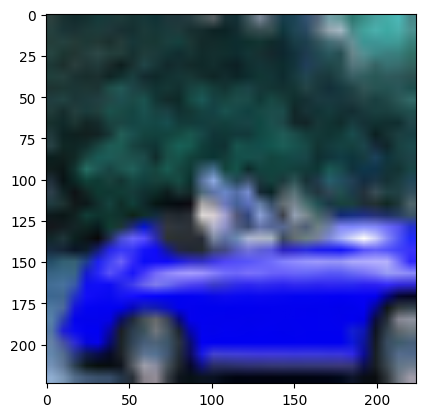

1


In [20]:
index = 2
img_temp = cv2.resize(image_dt[index],(224, 224))
plt.imshow(img_temp)
plt.show()
print(label_dt[index])

In [21]:
np.unique(label_dt)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [22]:
features_train, features_test, target_train, target_test = train_test_split(image_dt, label_dt, test_size = 0.2, random_state = 2)
print(image_dt.shape, features_train.shape, features_test.shape)
print(label_dt.shape, target_train.shape, target_test.shape)

(50000, 32, 32, 3) (40000, 32, 32, 3) (10000, 32, 32, 3)
(50000,) (40000,) (10000,)


# **Building own model**

In [14]:
import tensorflow as tf
tf.random.set_seed(3)
from tensorflow import keras

In [3]:
import tensorflow as tf

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available: 0
[]


In [15]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
])

In [16]:
model = keras.Sequential([
    keras.layers.Input(shape=(32, 32, 3)),
    data_augmentation,

    # Block 1
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.25),

    # Block 2
    keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.3),

    # Block 3
    keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.4),

    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(10, activation='softmax')
])

In [17]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    features_train,
    target_train,
    validation_split=0.1,
    epochs=5,
    batch_size=128
)

Epoch 1/5
 77/282 ━━━━━━━━━━━━━━━━━━━━ 1:16 374ms/step - accuracy: 0.2413 - loss: 2.7536

In [19]:
loss, accuracy = model.evaluate(features_test, target_test)
print(f'Accuracy on testing data is {accuracy:.2%}.')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6552 - loss: 2.2958
Accuracy on testing data is 65.52%.


# **Building Model using Torch**

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

torch.manual_seed(3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA available:", torch.cuda.is_available())

CUDA available: True


In [24]:
train_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.RandomResizedCrop(32, scale=(0.9, 1.0)),
])

test_transform = None  # no augmentation

In [25]:
X_train = torch.tensor(features_train, dtype=torch.float32).permute(0, 3, 1, 2)
y_train = torch.tensor(target_train, dtype=torch.long)

X_test  = torch.tensor(features_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test  = torch.tensor(target_test, dtype=torch.long)

In [26]:
val_size = int(0.1 * len(X_train))
train_size = len(X_train) - val_size

train_dataset, val_dataset = torch.utils.data.random_split(
    TensorDataset(X_train, y_train),
    [train_size, val_size]
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=128)
test_loader  = DataLoader(TensorDataset(X_test, y_test), batch_size=128)

In [27]:
# Block 1
conv1_1 = nn.Conv2d(3, 64, 3, padding=1).to(device)
bn1_1   = nn.BatchNorm2d(64).to(device)
conv1_2 = nn.Conv2d(64, 64, 3, padding=1).to(device)
bn1_2   = nn.BatchNorm2d(64).to(device)
pool1   = nn.MaxPool2d(2)
drop1   = nn.Dropout(0.25)

# Block 2
conv2_1 = nn.Conv2d(64, 128, 3, padding=1).to(device)
bn2_1   = nn.BatchNorm2d(128).to(device)
conv2_2 = nn.Conv2d(128, 128, 3, padding=1).to(device)
bn2_2   = nn.BatchNorm2d(128).to(device)
pool2   = nn.MaxPool2d(2)
drop2   = nn.Dropout(0.3)

# Block 3
conv3   = nn.Conv2d(128, 256, 3, padding=1).to(device)
bn3     = nn.BatchNorm2d(256).to(device)
pool3   = nn.MaxPool2d(2)
drop3   = nn.Dropout(0.4)

# Dense
fc1     = nn.Linear(256 * 4 * 4, 256).to(device)
bn_fc   = nn.BatchNorm1d(256).to(device)
drop_fc = nn.Dropout(0.5)
fc2     = nn.Linear(256, 10).to(device)

In [28]:
params = list(conv1_1.parameters()) + list(bn1_1.parameters()) + \
         list(conv1_2.parameters()) + list(bn1_2.parameters()) + \
         list(conv2_1.parameters()) + list(bn2_1.parameters()) + \
         list(conv2_2.parameters()) + list(bn2_2.parameters()) + \
         list(conv3.parameters())   + list(bn3.parameters())   + \
         list(fc1.parameters())     + list(bn_fc.parameters()) + \
         list(fc2.parameters())

optimizer = torch.optim.Adam(params)
criterion = nn.CrossEntropyLoss()

In [ ]:
from tqdm import tqdm

epochs = 5

for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    train_bar = tqdm(
        train_loader,
        desc=f"Epoch {epoch+1}/{epochs}",
        leave=False
    )

    for x, y in train_bar:
        x, y = x.to(device), y.to(device)

        # data augmentation
        x = torch.stack([train_transform(img) for img in x])

        optimizer.zero_grad()

        x = F.relu(bn1_1(conv1_1(x)))
        x = F.relu(bn1_2(conv1_2(x)))
        x = pool1(x)
        x = drop1(x)

        x = F.relu(bn2_1(conv2_1(x)))
        x = F.relu(bn2_2(conv2_2(x)))
        x = pool2(x)
        x = drop2(x)

        x = F.relu(bn3(conv3(x)))
        x = pool3(x)
        x = drop3(x)

        x = torch.flatten(x, 1)
        x = F.relu(bn_fc(fc1(x)))
        x = drop_fc(x)
        x = fc2(x)

        loss = criterion(x, y)
        loss.backward()
        optimizer.step()

        # ---- metrics ----
        running_loss += loss.item()

        preds = x.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

        avg_loss = running_loss / (train_bar.n + 1)
        acc = correct / total

        train_bar.set_postfix(
            loss=f"{avg_loss:.4f}",
            acc=f"{acc:.2%}"
        )

    print(
        f"Epoch {epoch+1}/{epochs} "
        f"- loss: {running_loss / len(train_loader):.4f} "
        f"- acc: {correct / total:.2%}"
    )

Epoch 1/5 - loss: 0.7508 - acc: 73.90%


Epoch 2/5 - loss: 0.7181 - acc: 74.89%


Epoch 3/5 - loss: 0.6899 - acc: 75.92%


Epoch 4/5 - loss: 0.6702 - acc: 76.78%


Epoch 5/5:   4%|█▊                                           | 11/282 [00:02<01:09,  3.92it/s, acc=76.56%, loss=0.6399]

# **ResNet50**

In [154]:
from tensorflow.keras import Sequential, models, layers
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import optimizers

In [155]:
convolution_base = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
convolution_base.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 36s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [157]:
model = models.Sequential()
model.add(layers.UpSampling2D((2,2)))
model.add(layers.UpSampling2D((2,2)))
model.add(layers.UpSampling2D((2,2)))
model.add(convolution_base)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(num_of_classes, activation='relu'))

In [160]:
model.compile(
    optimizer = optimizers.RMSprop(learning_rate=2e-5),
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    features_train,
    target_train,
    validation_split=0.1,
    epochs=1
)

  28/1125 ━━━━━━━━━━━━━━━━━━━━ 1:55:34 6s/step - accuracy: 0.1045 - loss: 9.2791